## Network Hubs

A hub in a scale-free network is generally the most well connected nodes. In a biological network, the hubs are usually the genes or proteins for essential cellular functions. Here, we study the functions of these hubs.

In [1]:
%matplotlib inline
import os 
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from collections import defaultdict, Counter
from operator import itemgetter
from IPython.display import Image, display
import networkx as nx
from src import misc, ora, geneset
import powerlaw
import multiprocessing

project_directory = '/projects/ooihs/ReNet'
final_directory = os.path.join(project_directory, 'results/final')
network_file = os.path.join(final_directory, 'integrated.network.uniprot')

data_directory = os.path.join(project_directory, 'data')
hgnc_file = os.path.join(data_directory, 'hgnc/hgnc_complete_set.json')
hgnc = misc.load_hgnc_json(hgnc_file)

map_directory = os.path.join(project_directory, 'results/map')

# load the interaction network as a graph
network = nx.Graph()

with open(network_file) as ifh:
    for line in ifh:
        col = line.strip().split('\t')
        network.add_edge(col[0], col[1])
        
# sort the proteins based on their degree
network_degrees = sorted(network.degree(), key=itemgetter(1), reverse=True)
print('Top 10 hubs:')

data = []
for n in network_degrees[:10]:
    protein, degree = n
    data.append((protein, hgnc['uniprot'][protein], degree))

result_degree = pd.DataFrame(data, columns=['Protein', 'Gene Symbol', 'Degree'])
result_degree

Top 10 hubs:


,Protein,Gene Symbol,Degree
0,P0CG48,UBC,10618
1,P14921,ETS1,9596
2,P23769,GATA2,7649
3,P67809,YBX1,6529
4,P10275,AR,6377
5,Q9BZS1,FOXP3,4611
6,P15976,GATA1,3437
7,P11142,HSPA8,3334
8,P03372,ESR1,3062
9,Q16254,E2F4,3054


Generally, all these proteins are involved in bioloigcal activities that are vital for cellular functions. The most highly connected protein is the Polyubiquitin-C (UBC), which can covalently bind to proteins and trigger various downstream processes. The  HSPA8 is a molecular chaperone, which is essential for ensuring the correct protein formation.  The remaining proteins are basically transcription factors or involved in transcription factor activity. 

The uniquitination is a universal process, therefore, it is understandable that the UBC could be bound to almost half of the human protein-coding genes. However, these interactions are too general and might not be useful for certain applications such as inferring biological functions from interacting partners. Similarly, transcription factor activity and interactions involving chaparone have to taken with care.

### KEGG pathways enriched in the top 100 hub proteins

In [2]:
# performance analysis of the top 100 proteins
proteins = [p[0] for p in network_degrees[:100]]

kegg_file = os.path.join(map_directory, 'pathway.kegg.uniprot')
# load kegg profiles with members between 2 and 250
kegg, gene2kegg = geneset.load_as_profiles(kegg_file, 2, 250)

kegg_count = defaultdict(int)
for p in proteins:
    if p in gene2kegg:
        for pid in gene2kegg[p]:
            kegg_count[pid] += 1
            
sorted_kegg = sorted(kegg_count.items(), key=itemgetter(1), reverse=True)
data = []
for item in sorted_kegg:
    kid, count = item
    # get the pathway name
    pname = kegg[kid][0]
    pname = pname[:pname.find(' - ')]
    data.append((kid, pname, count))
    if len(data) > 30:
        break

result_hub_kegg_count = pd.DataFrame(data, columns=['Pathway ID', 'Name', 'Count'])
result_hub_kegg_count

,Pathway ID,Name,Count
0,hsa05169,Epstein-Barr virus infection,25
1,hsa04915,Estrogen signaling pathway,17
2,hsa05164,Influenza A,15
3,hsa05203,Viral carcinogenesis,15
4,hsa04141,Protein processing in endoplasmic reticulum,14
5,hsa05162,Measles,13
6,hsa05215,Prostate cancer,12
7,hsa04114,Oocyte meiosis,12
8,hsa05134,Legionellosis,12
9,hsa05205,Proteoglycans in cancer,12


In [3]:
# enrichment test, listed only the top 30 most significant pathways
background_proteins = list(hgnc['uniprot'].keys())
result_hub_kegg = ora.protein_test(proteins, kegg_file, len(background_proteins), max_results=30)
result_hub_kegg

,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome
0,hsa05169,Epstein-Barr virus infection,2.308185e-28,4.270142e-26,25/100,199/20030
1,hsa04915,Estrogen signaling pathway,5.889887e-22,5.448145e-20,17/100,98/20030
2,hsa05134,Legionellosis,4.458497e-17,2.749407e-15,12/100,55/20030
3,hsa05164,Influenza A,6.764440e-15,3.128554e-13,15/100,171/20030
4,hsa04540,Gap junction,1.582277e-14,5.854426e-13,12/100,87/20030
5,hsa05203,Viral carcinogenesis,2.017705e-14,6.221257e-13,15/100,184/20030
6,hsa05215,Prostate cancer,6.105536e-14,1.613606e-12,12/100,97/20030
7,hsa04141,Protein processing in endoplasmic reticulum,8.343579e-14,1.929453e-12,14/100,164/20030
8,hsa05162,Measles,1.058656e-13,2.176125e-12,13/100,132/20030
9,hsa05130,Pathogenic Escherichia coli infection,1.210364e-13,2.239173e-12,10/100,54/20030


Many of the proteins involved in various cancers and diseases, where on average, cancer-associated genes or proteins have been shown to have more interacting partners than non-cancer related genes[1]. Furthermore, the hub proteins are also essential for survival[2]. For example, pathways such as Estrogen signaling, apoptosis, gap junction and cell cycle are generally involved in the growth, development, reproduction and maintenance of cells. 

[1]: [Jonsson PF and Bates PA. Global topological features of cancer proteins in the human interactome. Bioinformatics 2006, 22:2291-2297.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1865486/)

[2]: [Jeong H, et al. Lethality and centrality in protein networks. Nature 2001, 411:41–42.](https://www.ncbi.nlm.nih.gov/pubmed/11333967)

## What are the enriched pathways if we randomly choose 100 proteins from the integrated network?

In [4]:
num_permutation = 1000

# hold the list of enriched pathways for each test
results = []

np.random.seed(1244022)
for i in range(num_permutation):
    # randomly select the proteins without replacement
    test_proteins = np.random.choice(network.nodes(), 100, replace=False)
    results.append(ora.protein_test(test_proteins, 
                                    kegg_file, 
                                    len(background_proteins), 
                                    max_results=30))
    

kegg_count = Counter()
empty_result_count = 0
for r in results:
    if not r.empty:
        kegg_count.update(r['Name'])
    else:
        empty_result_count += 1
        
print('Number of empty result:', empty_result_count)
result_random_kegg = pd.DataFrame(list(kegg_count.items()), columns=['Pathway', 'Count'])
# display only pathways observed multiple times
result_random_kegg[result_random_kegg['Count'] > 1]

Number of empty result: 953


,Pathway,Count
0,Arrhythmogenic right ventricular cardiomyopath...,2
1,Hypertrophic cardiomyopathy (HCM),2
4,Glycosaminoglycan biosynthesis,2
6,Long-term depression,2
12,Aldosterone synthesis and secretion,2
17,Small cell lung cancer,2
20,Porphyrin and chlorophyll metabolism,2
25,Huntington's disease,2
44,Herpes simplex infection,2
45,Glycosphingolipid biosynthesis,2


## Are the hub proteins are enriched in physiological important pathway?

Generally, the top hundred hub proteins are enriched with several physiological important pathways such as Estrogen signaling pathway, gap junction and apoptosis. Here, we performed a permutation test to test whether the following physiological important pathways are significant.

In [5]:
selected_pathways = ['hsa04210', 'hsa04110', 'hsa04114', 'hsa04530', 'hsa04540', 'hsa04915']
selected_pathway_table = result_hub_kegg_count[result_hub_kegg_count['Pathway ID'].isin( selected_pathways)]
selected_pathway_table

,Pathway ID,Name,Count
1,hsa04915,Estrogen signaling pathway,17
7,hsa04114,Oocyte meiosis,12
12,hsa04540,Gap junction,12
15,hsa04210,Apoptosis,11
23,hsa04530,Tight junction,10
28,hsa04110,Cell cycle,9


We can perform a permutation test to estimate the significance of these pathways by using the following method:

1. Generate 1000 random proteins from the global network.
2. Identify the number of proteins in each set above that are part of the selected pathways.
3. Compare the observed number of hub proteins to the distribution generated in step 2 and calculate an estimated p-value.

The second step generates a series of empirical null distributions of associations between the proteins and the corresponding pathways. Here, the null hypothesis states that any randomly selected set of 100 proteins will contains similar number proteins associated with the selected pathway.

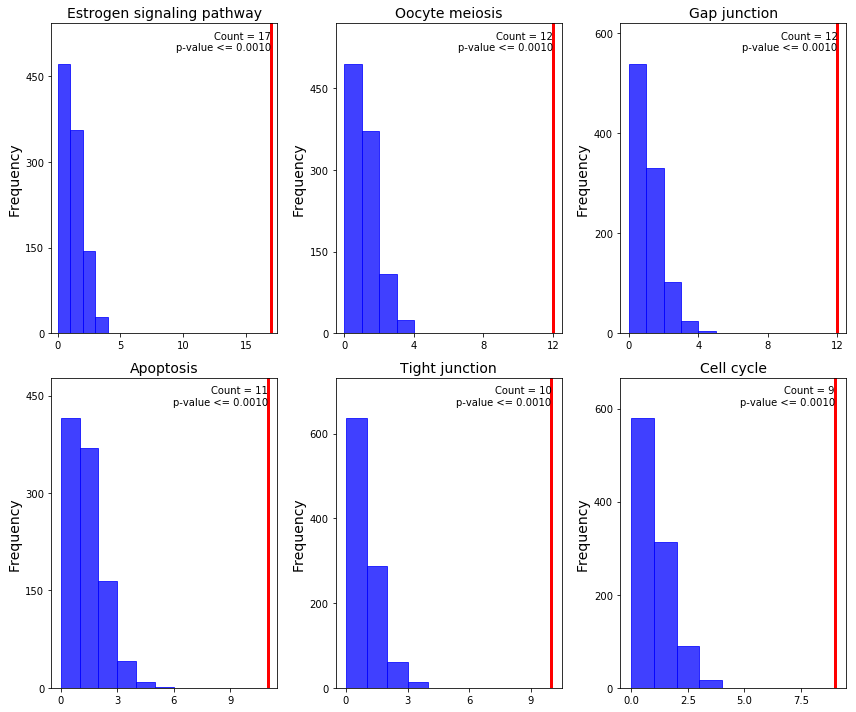

In [6]:
# load the kegg profiles
kegg_profiles = geneset.load(kegg_file) 

def pathway_test(args):    
    """calculate the number of random proteins appear in the selected pathways"""
    rproteins, pathways, profiles = args
    
    results = []
    for p in pathways:
        results.append(len(set(rproteins) & set(profiles[p])))
    return results


def pathway_permuation_test(num_permutation, protein_size, network, pathways, profiles, number_of_workers=1):
    """perform a permutation on the selected pathways"""

    # execute the job parallely
    process_list = []
    for i in range(num_permutation):
        np.random.seed(i+11223)
        # randomly select the proteins without replacement
        rproteins = np.random.choice(network.nodes(), protein_size, replace=False)
        
        process_list.append((rproteins, pathways, profiles))
    
    pool = multiprocessing.Pool(number_of_workers)
    info = pool.imap_unordered(pathway_test, process_list)

    pool.close()
    pool.join()

    # collect the run statistics
    count = []
    for i in pathways:
        count.append(list(np.zeros(num_permutation)))

    for i, item in enumerate(info):
        for j in range(len(pathways)):
            count[j][i] = item[j]

           
    return count



# for demonstration purpose, we set the number of permutation to 1000, in 
# reality, it is better to set it to at least 10,000
num_permutation = 1000

count = pathway_permuation_test(num_permutation, 100, network, 
                                selected_pathways, kegg_profiles, 20)


image_file = os.path.join(project_directory, 'results/images/permutation_test_important_kegg_pathways.png')


# calculate the p-values and plot the graph
# generally, we cannot have an empirical p-value of 0, as we only draw
# a subset of all possible combinations for the permutation test
pvalues = []

stats = list(selected_pathway_table['Count'])
labels = list(selected_pathway_table['Name'])

# figure of size 12x8 inches
fig, ax = plt.subplots(2, 3, figsize=(12, 10))

for i in range(len(selected_pathways)):
    x = int(i/3)
    y = int(i%3)

    pvalue = 1.0/num_permutation
    if not all(count[i] < stats[i]):
        observed = np.size(np.where(count[i] >= stats[i]))
        pvalue = np.float(observed)/num_permutation

    # plot the proteins distribution
    data_range = max(count[i]) - min(count[i])
    # draw histogram
    freq, bins, patches = ax[x,y].hist(count[i], np.int(data_range),
                                     facecolor='b', edgecolor='b',
                                     alpha=0.75, color='b')
    max_freq = max(freq)
    # draw the test statistic, and provide some description
    ax[x,y].axvline(stats[i], linewidth=3, color='r')
    text_pos = 'center'
    if max(count[i]) - stats[i] < 2:
        text_pos = 'right'
    ax[x,y].text(stats[i], 1.05*np.float(max_freq),
                 ('Count = {}'.format(stats[i]) + 
                 '\np-value <= {:.4f}'.format(pvalue)),
                 horizontalalignment=text_pos, fontsize=10)

    # adjust the axes
    ax[x,y].set_title(labels[i], fontsize=14)
    ax[x,y].set_ylim(0, max_freq*1.15)
    yticks = plt.MaxNLocator(4)
    ax[x,y].yaxis.set_major_locator(yticks)
    ax[x,y].set_ylabel('Frequency', fontsize=14)

    max_bins = max([max(bins), stats[i]])
    ax[x,y].set_xlim(min(bins)-0.5, max_bins+0.5)
    xticks = plt.MaxNLocator(4)
    ax[x,y].xaxis.set_major_locator(xticks)

fig.tight_layout()
fig.savefig(image_file, dpi=300)
plt.show()
plt.close(fig)

## Gene Ontology analysis

Gene Ontology defines concepts for three major biological domains: molecular function, biological process and cellular component. Therefore, we can use it to study different aspects of genes or gene products.

In [7]:
from src import go

# load the gene ontology as a graph
go_file = os.path.join(data_directory, 'go/go.obo')
go.parse(go_file)

goa_file = os.path.join(map_directory, 'geneontology.goa.uniprot')
goa, gene2goa = geneset.load_as_profiles(goa_file)

### Molecular functions of the top 10 hubs

In [8]:
mf_count = Counter()

# for each hub
for p in result_degree['Protein']:
    # update the counter with the list of annotation associated with the
    # protein
    mf_count.update(
        [ann.split('|')[1] for ann in gene2goa[p] if ann.startswith('F|')]
    )

result_mf = pd.DataFrame(list(mf_count.items()), columns=['GO ID', 'Count'])

# get the go name
gonames = [go.get_term_name(goid) for goid in result_mf['GO ID']]

# update the table with go name
result_mf.insert(loc=1, 
                 column='Molecular Function', 
                 value=gonames)

# sort the table
result_mf = result_mf.sort_values(by="Count", ascending=False)

# display only pathways observed multiple times
result_mf[result_mf['Count'] > 1]

,GO ID,Molecular Function,Count
0,GO:0005515,protein binding,10
4,GO:0003700,DNA binding transcription factor activity,8
12,GO:0003677,DNA binding,5
3,GO:0000978,RNA polymerase II proximal promoter sequence-s...,5
6,GO:0008134,transcription factor binding,5
7,GO:0001077,"transcriptional activator activity, RNA polyme...",5
1,GO:0003723,RNA binding,3
9,GO:0003682,chromatin binding,3
16,GO:0019899,enzyme binding,3
26,GO:0043565,sequence-specific DNA binding,2


### Biological processes for the top 10 hubs

In [9]:
bp_count = Counter()

# for each hub
for p in result_degree['Protein']:
    # update the counter with the list of annotation associated with the
    # protein
    bp_count.update(
        [ann.split('|')[1] for ann in gene2goa[p] if ann.startswith('P|')]
    )

result_bp = pd.DataFrame(list(bp_count.items()), columns=['GO ID', 'Count'])

# get the go name
gonames = [go.get_term_name(goid) for goid in result_bp['GO ID']]

# update the table with go name
result_bp.insert(loc=1, column='Biological Process', value=gonames)

# sort the table
result_bp = result_bp.sort_values(by="Count", ascending=False)

# display only pathways observed multiple times
result_bp[result_bp['Count'] > 1]

,GO ID,Biological Process,Count
5,GO:0045944,positive regulation of transcription from RNA ...,9
79,GO:0045893,"positive regulation of transcription, DNA-temp...",5
3,GO:0000122,negative regulation of transcription from RNA ...,4
104,GO:0006355,"regulation of transcription, DNA-templated",3
30,GO:1902036,regulation of hematopoietic stem cell differen...,3
94,GO:0006351,"transcription, DNA-templated",3
17,GO:0016579,protein deubiquitination,3
102,GO:0006366,transcription from RNA polymerase II promoter,3
81,GO:0008285,negative regulation of cell proliferation,3
103,GO:0000398,"mRNA splicing, via spliceosome",2


### Visualize the molecular functions of top 10 hubs

The gene ontology concepts are organized in a directed acyclic graph (DAG). A DAG is a directed graph with no directed cycles. Generally, it is a tree-like structure that has a clear parent and child relationships. Let's say we have 3 nodes, A, B, C. The following graph with three relationships is a DAG,
```
A -> B
A -> C
B -> C
```
However, the following graph with a directed cycle is not a DAG,
```
A -> B
B -> C
C -> A
```
This is because we cannot decode the parent-child relationship from this graph. 

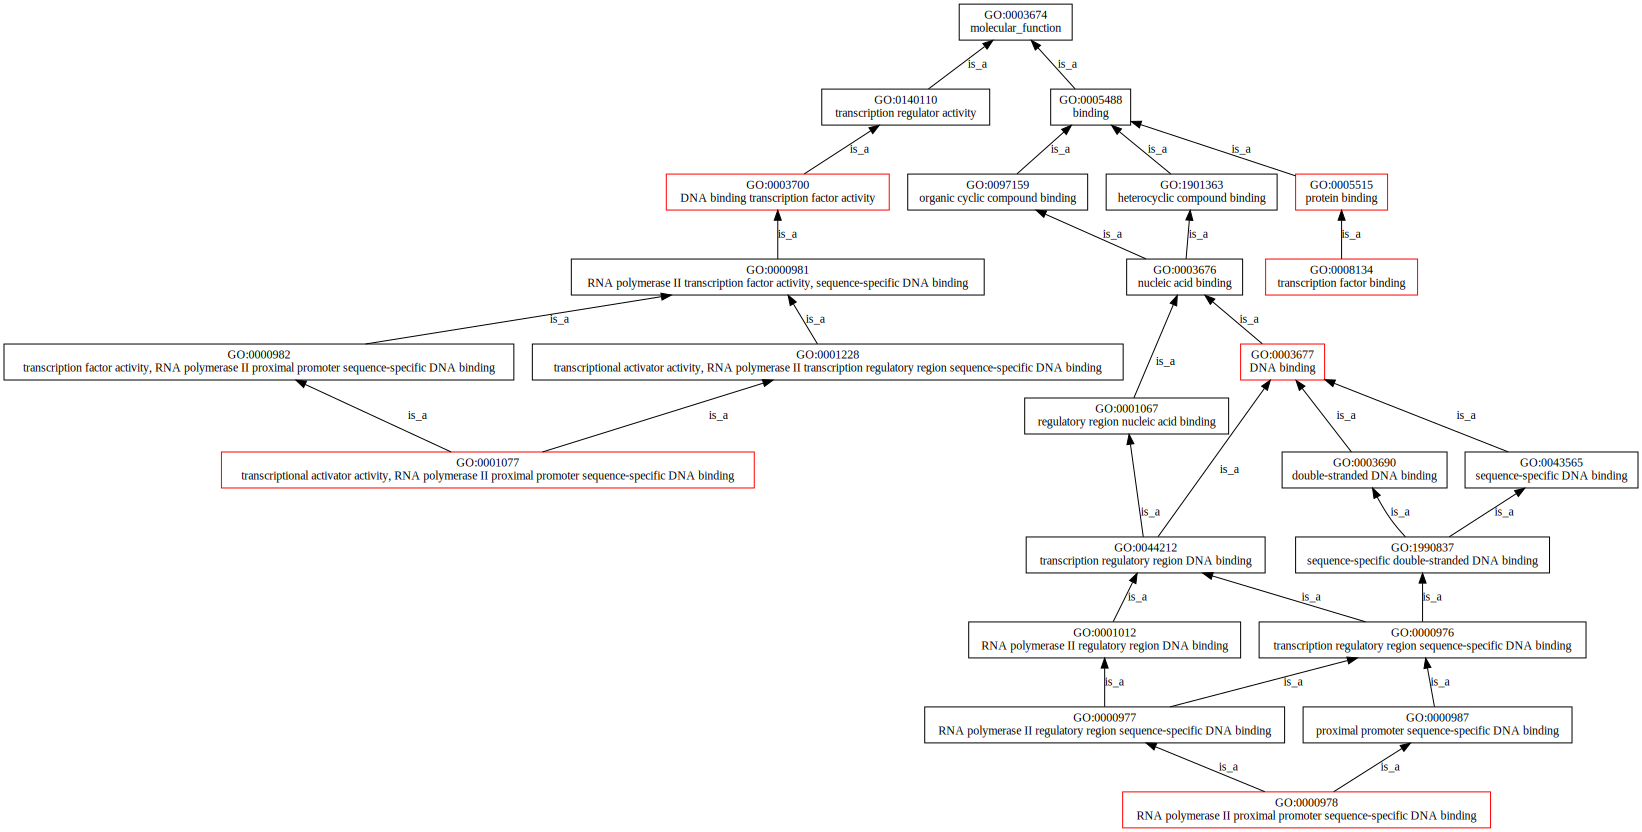

In [10]:
terms = list(result_mf[result_mf['Count'] >= 5]['GO ID'])
go.draw_graph_multi(terms)

The above figure shows that the molecular functions of the top 10 proteins can be grouped into three mjoar classes, DNA binding, protein binding, DNA binding transcription factor activity. 

### What are the biological processes enriched in the top 100 hubs

The gene association file provided by EBI contains associations for all three concepts. Here, we first extracted all biological processes into a separate file.

In [11]:
!grep 'P|' {goa_file} > {goa_file}.bp

In [12]:
# performance analysis of the top 100 proteins
proteins = [p[0] for p in network_degrees[:100]]

gobp_file = goa_file + '.bp'
# load profiles with members between 2 and 250
gobp, gene2gobp = geneset.load_as_profiles(gobp_file, 2, 250)

gobp_count = defaultdict(int)
for p in proteins:
    if p in gene2gobp:
        for pid in gene2gobp[p]:
            gobp_count[pid] += 1
            
sorted_gobp = sorted(gobp_count.items(), key=itemgetter(1), reverse=True)
data = []
for item in sorted_gobp:
    goid, count = item
    goid = goid.split('|')[1]
    # get the pathway name
    pname = go.get_term_name(goid)
    data.append((goid, pname, count))
    if len(data) > 30:
        break

result_hub_gobp_count = pd.DataFrame(data, columns=['GO ID', 'Biological Process', 'Count'])
result_hub_gobp_count

,GO ID,Biological Process,Count
0,GO:0000086,G2/M transition of mitotic cell cycle,17
1,GO:0016579,protein deubiquitination,15
2,GO:0061024,membrane organization,14
3,GO:0038095,Fc-epsilon receptor signaling pathway,13
4,GO:0000165,MAPK cascade,13
5,GO:0043488,regulation of mRNA stability,12
6,GO:0051092,positive regulation of NF-kappaB transcription...,12
7,GO:0002223,stimulatory C-type lectin receptor signaling p...,11
8,GO:0043161,proteasome-mediated ubiquitin-dependent protei...,11
9,GO:0006457,protein folding,11


Similarly, the observed biological processes are mainly essential cellular processes.

### What the enriched biological processes if we randomly choose 100 proteins?

In [13]:
num_permutation = 1000

# hold the list of enriched pathways for each test
results = []

np.random.seed(1244022)
for i in range(num_permutation):
    # randomly select the proteins without replacement
    test_proteins = np.random.choice(network.nodes(), 100, replace=False)
    results.append(ora.protein_test(test_proteins, 
                                    gobp_file, 
                                    len(background_proteins), 
                                    max_results=30))
    
gobp_count = Counter()
empty_result_count = 0
for r in results:
    if not r.empty:
        gobp_count.update(r['Name'])
    else:
        empty_result_count += 1
        
print('Number of empty result:', empty_result_count)
data = []
for item in gobp_count:
    goid = item.split('|')[1]
    data.append((goid, go.get_term_name(goid), gobp_count.get(item)))
result_random_gobp = pd.DataFrame(data, 
                                  columns=['GO ID','Biological Processes', 
                                           'Count'])
# display only pathways observed multiple times
result_random_gobp[result_random_gobp['Count'] > 1]

Number of empty result: 910


,GO ID,Biological Processes,Count
9,GO:0030593,neutrophil chemotaxis,2
19,GO:0001937,negative regulation of endothelial cell prolif...,2
50,GO:0016239,positive regulation of macroautophagy,2
55,GO:0007077,mitotic nuclear envelope disassembly,2


### Test the significance of the observed top 15 biological processes

In [14]:
selected_pathway_table = result_hub_gobp_count[result_hub_gobp_count['Count'] > 10]
selected_pathway_table

,GO ID,Biological Process,Count
0,GO:0000086,G2/M transition of mitotic cell cycle,17
1,GO:0016579,protein deubiquitination,15
2,GO:0061024,membrane organization,14
3,GO:0038095,Fc-epsilon receptor signaling pathway,13
4,GO:0000165,MAPK cascade,13
5,GO:0043488,regulation of mRNA stability,12
6,GO:0051092,positive regulation of NF-kappaB transcription...,12
7,GO:0002223,stimulatory C-type lectin receptor signaling p...,11
8,GO:0043161,proteasome-mediated ubiquitin-dependent protei...,11
9,GO:0006457,protein folding,11


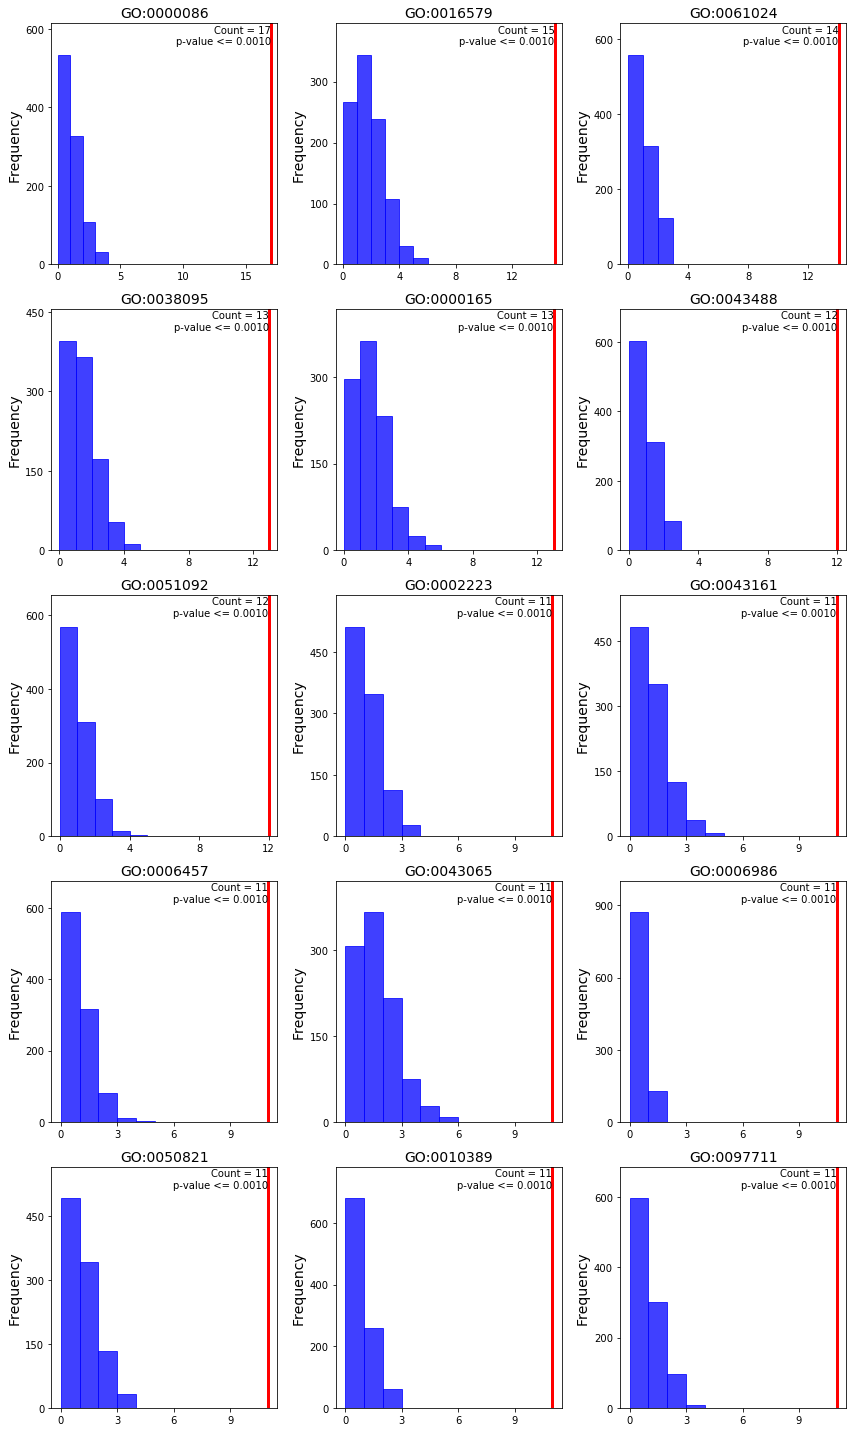

In [15]:
# for demonstration purpose, we set the number of permutation to 1000, in 
# reality, it is better to set it to at least 10,000
num_permutation = 1000

gobp_profiles = geneset.load(gobp_file) 

selected_pathways = ['P|' + goid for goid in selected_pathway_table['GO ID']]
count = pathway_permuation_test(num_permutation, 100, network, 
                                selected_pathways, gobp_profiles, 20)

image_file = os.path.join(project_directory, 'results/images/permutation_test_important_gobp.png')


# calculate the p-values and plot the graph
# generally, we cannot have an empirical p-value of 0, as we only draw
# a subset of all possible combinations for the permutation test
pvalues = []

stats = list(selected_pathway_table['Count'])
labels = list(selected_pathway_table['GO ID'])

# figure of size 12x8 inches
fig, ax = plt.subplots(5, 3, figsize=(12, 20))

for i in range(len(selected_pathways)):
    x = int(i/3)
    y = int(i%3)

    pvalue = 1.0/num_permutation
    if not all(count[i] < stats[i]):
        observed = np.size(np.where(count[i] >= stats[i]))
        pvalue = np.float(observed)/num_permutation

    # plot the proteins distribution
    data_range = max(count[i]) - min(count[i])
    # draw histogram
    freq, bins, patches = ax[x,y].hist(count[i], np.int(data_range),
                                     facecolor='b', edgecolor='b',
                                     alpha=0.75, color='b')
    max_freq = max(freq)
    # draw the test statistic, and provide some description
    ax[x,y].axvline(stats[i], linewidth=3, color='r')
    text_pos = 'center'
    if max(count[i]) - stats[i] < 2:
        text_pos = 'right'
    ax[x,y].text(stats[i], 1.05*np.float(max_freq),
                 ('Count = {}'.format(stats[i]) + 
                 '\np-value <= {:.4f}'.format(pvalue)),
                 horizontalalignment=text_pos, fontsize=10)

    # adjust the axes
    ax[x,y].set_title(labels[i], fontsize=14)
    ax[x,y].set_ylim(0, max_freq*1.15)
    yticks = plt.MaxNLocator(4)
    ax[x,y].yaxis.set_major_locator(yticks)
    ax[x,y].set_ylabel('Frequency', fontsize=14)

    max_bins = max([max(bins), stats[i]])
    ax[x,y].set_xlim(min(bins)-0.5, max_bins+0.5)
    xticks = plt.MaxNLocator(4)
    ax[x,y].xaxis.set_major_locator(xticks)

fig.tight_layout()
fig.savefig(image_file, dpi=300)
plt.show()
plt.close(fig)